In [ ]:
import h5py
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import pandas as pd


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jun 15 13:56:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
combined_df_seqlabelled_sentence_short = pd.read_json('/content/drive/MyDrive/thesis_files/combined_df_seqlabelled_sentence_short_renamed.json', orient='records', lines=True)

In [ ]:
# Get the 'tagged_text' column from the DataFrame
tagged_data = combined_df_seqlabelled_sentence_short['tagged_text'].tolist()



In [ ]:
# Get unique words and labels
words = list(set(token for seq in tagged_data for token, label in seq))
tags = list(set(label for seq in tagged_data for token, label in seq))

In [ ]:
def get_max_lengths(tagged_data):
    max_sentence_length = 0
    max_document_length = 0

    for document in tagged_data:
        max_document_length = max(max_document_length, len(document))
        for sentence, label in document:
            max_sentence_length = max(max_sentence_length, len(sentence.split()))

    return max_sentence_length, max_document_length

max_sentence_length, max_document_length = get_max_lengths(tagged_data)
print(max_sentence_length, max_document_length)

32107 811


In [ ]:
max_sentence_length = 700

new_tagged_data = []
for document in tagged_data:
    new_document = [(sentence, label) for sentence, label in document if len(sentence.split()) <= max_sentence_length]

    # Only add the document to new_tagged_data if it's not empty
    if new_document:
        new_tagged_data.append(new_document)

tagged_data = new_tagged_data

In [ ]:
### splitting documents ###

def split_documents(dataset, n):
    new_dataset = []
    for document in dataset:
        for i in range(0, len(document), n):
            new_document = document[i:i+n]
            new_dataset.append(new_document)
    return new_dataset


In [ ]:
tagged_data_short = split_documents(tagged_data, 150)

In [ ]:
tagged_data_short = tagged_data_short[:500]

In [ ]:
tagged_data = tagged_data_short

In [ ]:
print(len(tagged_data))

16037


In [ ]:
print(tagged_data[0])

[('NatGen : Generative pre-training by “Naturalizing” source code\nSaikat Chakraborty\nColumbia University\nNew York, NY, USA\nsaikatc@cs.columbia.eduToufique Ahmed\nUniversity of California, Davis\nDavis, CA, USA\ntfahmed@ucdavis.eduYangruibo Ding\nColumbia University\nNew York, NY, USA\nyrbding@cs.columbia.edu\nPremkumar Devanbu\nUniversity of California, Davis\nDavis, CA, USA\nptdevanbu@ucdavis.eduBaishakhi Ray\nColumbia University\nNew York, NY, USA\nrayb@cs.columbia.edu\nAbstract\nPre-trained Generative Language models ( e.g.,PLBART, CodeT5,\nSPT-Code) for source code yielded strong results on several tasks\nin the past few years, including code generation and translation.', 'highlight'), ('These models have adopted varying pre-training objectives to learn\nstatistics of code construction from very large-scale corpora in a\nself-supervised fashion; the success of pre-trained models largely\nhinges on these pre-training objectives.', 'highlight'), ('This paper proposes a new\npre-t

In [ ]:
print(tagged_data[0][0])

('NatGen : Generative pre-training by “Naturalizing” source code\nSaikat Chakraborty\nColumbia University\nNew York, NY, USA\nsaikatc@cs.columbia.eduToufique Ahmed\nUniversity of California, Davis\nDavis, CA, USA\ntfahmed@ucdavis.eduYangruibo Ding\nColumbia University\nNew York, NY, USA\nyrbding@cs.columbia.edu\nPremkumar Devanbu\nUniversity of California, Davis\nDavis, CA, USA\nptdevanbu@ucdavis.eduBaishakhi Ray\nColumbia University\nNew York, NY, USA\nrayb@cs.columbia.edu\nAbstract\nPre-trained Generative Language models ( e.g.,PLBART, CodeT5,\nSPT-Code) for source code yielded strong results on several tasks\nin the past few years, including code generation and translation.', 'highlight')


In [ ]:
# Tokenize words
word_tokenizer = Tokenizer(num_words=len(words), oov_token='OOV')
chunk_size = 10000  # Change this value depending on the memory capacity of your machine
sentences = [sentence for seq in tagged_data for sentence, _ in seq]  # get the sentences from tagged_data

# fit on texts in chunks
for i in range(0, len(sentences), chunk_size):
    word_tokenizer.fit_on_texts(sentences[i:i+chunk_size])

# Tokenize tags
labels = [label for seq in tagged_data for _, label in seq]
tag_tokenizer = Tokenizer(lower=False, num_words=None)  # turn off lowercasing and limiting the number of words
tag_tokenizer.fit_on_texts(labels)

In [ ]:
### label on sentence level ###


def process_chunk(chunk, max_sentence_length):
    X_chunk = []
    y_chunk = []

    for seq in chunk:
        document_sentences = []
        document_labels = []

        for sentence, label in seq:
            # Transform each sentence to a sequence of numeric IDs
            encoded_sentence = word_tokenizer.texts_to_sequences([sentence])[0]
            encoded_sentence = pad_sequences([encoded_sentence], maxlen=max_sentence_length, padding='post')[0]

            # Encode the label for the sentence
            encoded_label = tag_tokenizer.texts_to_sequences([label])[0]

            # No need to replicate label for all tokens in the sentence

            document_sentences.append(encoded_sentence)
            document_labels.append(encoded_label[0])  # add the first element since encoded_label is a list of lists

        X_chunk.append(document_sentences)
        y_chunk.append(document_labels)

    return X_chunk, y_chunk

    # Divide the data into chunks
chunk_size = 1000  # Adjust as needed
chunks = chunker(tagged_data, chunk_size)

max_sentence_length = 150  # set intentionally or use the function above
max_document_length = 150

# Process each chunk and combine the results
X = []
y = []

for chunk in chunks:
    X_chunk, y_chunk = process_chunk(chunk, max_sentence_length)

    # Pad each document to max_document_length
    X_chunk = pad_sequences(X_chunk, maxlen=max_document_length, padding='post', dtype='int32')

    # Padding y_chunk to max_document_length with a specific padding label (e.g., 0)
    y_chunk = [np.pad(document_labels, (0, max_document_length - len(document_labels)), 'constant', constant_values=0)
               for document_labels in y_chunk]

    X.extend(X_chunk)
    y.extend(y_chunk)



In [ ]:
def chunker(seq, size):
    """Divide a sequence into chunks of the given size."""
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

In [ ]:
### tokenize train / test seperately ###

def chunker(seq, size):
    """Divide a sequence into chunks of the given size."""
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

# First, split your tagged_data into a training set and a test set
split_index = int(len(tagged_data) * 0.8)
train_data = tagged_data[:split_index]
test_data = tagged_data[split_index:]

# Training data
train_sentences = [sentence for seq in train_data for sentence, _ in seq]  # get the sentences from train_data
train_labels = [label for seq in train_data for _, label in seq]  # get the labels from train_data

# Testing data
test_sentences = [sentence for seq in test_data for sentence, _ in seq]  # get the sentences from test_data
test_labels = [label for seq in test_data for _, label in seq]  # get the labels from test_data

# Tokenize words separately for training and testing data
word_tokenizer_train = Tokenizer(oov_token='OOV')
word_tokenizer_test = Tokenizer(oov_token='OOV')

# fit on texts in chunks for training data
chunk_size = 10000  # Change this value depending on the memory capacity of your machine
for i in range(0, len(train_sentences), chunk_size):
    word_tokenizer_train.fit_on_texts(train_sentences[i:i+chunk_size])

# fit on texts in chunks for testing data
for i in range(0, len(test_sentences), chunk_size):
    word_tokenizer_test.fit_on_texts(test_sentences[i:i+chunk_size])

# Tokenize labels
tag_tokenizer = Tokenizer(lower=False)  # turn off lowercasing and limiting the number of words
tag_tokenizer.fit_on_texts(train_labels + test_labels)  # fit on both training and testing labels



def process_chunk(chunk, max_sentence_length, word_tokenizer, tag_tokenizer):
    X_chunk = []
    y_chunk = []

    for seq in chunk:
        document_sentences = []
        document_labels = []

        for sentence, label in seq:
            # Transform each sentence to a sequence of numeric IDs
            encoded_sentence = word_tokenizer.texts_to_sequences([sentence])[0]
            encoded_sentence = pad_sequences([encoded_sentence], maxlen=max_sentence_length, padding='post')[0]

            # Encode the label for the sentence
            encoded_label = tag_tokenizer.texts_to_sequences([label])[0]

            # No need to replicate label for all tokens in the sentence
            document_sentences.append(encoded_sentence)
            document_labels.append(encoded_label[0])  # add the first element since encoded_label is a list of lists

        X_chunk.append(document_sentences)
        y_chunk.append(document_labels)

    return X_chunk, y_chunk

def pad_documents(X, max_document_length, max_sentence_length):
    padded_X = []

    for document in X:
        # Pad each sentence in the document
        padded_sentences = pad_sequences(document, maxlen=max_sentence_length, padding='post')

        # If the document has less sentences than max_document_length, pad with sentences of zeros
        if len(padded_sentences) < max_document_length:
            padding = np.zeros((max_document_length - len(padded_sentences), max_sentence_length), dtype=int)
            padded_sentences = np.concatenate([padded_sentences, padding])

        # If the document has more sentences than max_document_length, truncate
        elif len(padded_sentences) > max_document_length:
            padded_sentences = padded_sentences[:max_document_length]

        padded_X.append(padded_sentences)

    return np.array(padded_X)

max_sentence_length = 150
max_document_length = 150 # adjust this to your needs
# ... other parts of your code

def pad_documents(X, max_document_length, max_sentence_length):
    padded_X = []

    for document in X:
        # Pad each sentence in the document
        padded_sentences = pad_sequences(document, maxlen=max_sentence_length, padding='post')

        # If the document has less sentences than max_document_length, pad with sentences of zeros
        if len(padded_sentences) < max_document_length:
            padding = np.zeros((max_document_length - len(padded_sentences), max_sentence_length), dtype=int)
            padded_sentences = np.concatenate([padded_sentences, padding])

        # If the document has more sentences than max_document_length, truncate
        elif len(padded_sentences) > max_document_length:
            padded_sentences = padded_sentences[:max_document_length]

        padded_X.append(padded_sentences)

    return np.array(padded_X)

# ... other parts of your code

X_train = []
y_train = []
X_test = []
y_test = []

for chunk in chunker(train_data, chunk_size):
    X_chunk, y_chunk = process_chunk(chunk, max_sentence_length, word_tokenizer_train, tag_tokenizer)
    X_train.extend(X_chunk)
    y_train.extend(y_chunk)

for chunk in chunker(test_data, chunk_size):
    X_chunk, y_chunk = process_chunk(chunk, max_sentence_length, word_tokenizer_test, tag_tokenizer)
    X_test.extend(X_chunk)
    y_test.extend(y_chunk)

# Pad documents in the training and test data
X_train = pad_documents(X_train, max_document_length, max_sentence_length)
X_test = pad_documents(X_test, max_document_length, max_sentence_length)

# Pad labels in the training and test data
y_train = pad_sequences(y_train, maxlen=max_document_length, padding='post')
y_test = pad_sequences(y_test, maxlen=max_document_length, padding='post')



In [ ]:
print(len(X_train[0][0]))

150


In [ ]:
print(len(y_test[0]))

58


In [ ]:
print(X_train[1][0])

In [ ]:
def decode_entry(X_entry, y_entry, word_tokenizer, tag_tokenizer):
    reverse_word_index = dict(map(reversed, word_tokenizer.word_index.items()))
    reverse_label_index = dict(map(reversed, tag_tokenizer.word_index.items()))

    # Decode the entry
    decoded_X = [[reverse_word_index.get(i, '?') for i in sentence] for sentence in X_entry]
    decoded_y = [reverse_label_index.get(i, '?') for i in y_entry]

    return decoded_X, decoded_y

def print_entry(entry_id, X_data, y_data, word_tokenizer, tag_tokenizer):
    X_entry = X_data[entry_id]
    y_entry = y_data[entry_id]

    decoded_X, decoded_y = decode_entry(X_entry, y_entry, word_tokenizer, tag_tokenizer)

    print("Tokenized data:")
    print("X:", X_entry)
    print("y:", y_entry)

    print("\nDecoded data:")
    print("X:", decoded_X)
    print("y:", decoded_y)


In [ ]:
entry_id = 0  # Replace with the id of the entry you want to print
print_entry(entry_id, X_train, y_train, word_tokenizer_train, tag_tokenizer)

In [ ]:
folder_path = "/content/drive/MyDrive/thesis_files/"

In [ ]:
### save the sentence-labelled data ###

import h5py

# Specify the path to the folder where you want to save the files


# Save X data
with h5py.File(f'{folder_path}X_data_sentlabel.h5', 'w') as hf:
    hf.create_dataset("X_data",  data=np.array(X))

# Save y data
with h5py.File(f'{folder_path}y_data_sentlabel.h5', 'w') as hf:
    hf.create_dataset("y_data",  data=np.array(y))


In [ ]:
# Load X data
with h5py.File(f'{folder_path}X_data_sentlabel.h5', 'r') as hf:
    X = hf['X_data'][:]

# Load y data
with h5py.File(f'{folder_path}y_data_sentlabel.h5', 'r') as hf:
    y = hf['y_data'][:]


In [ ]:
lengths = [len(x) for x in X_train]

# Check if all lengths are equal to the first one
if len(set(lengths)) == 1:
    print("All sequences are of the same length.")
else:
    print("Sequences have varying lengths.")
    print(set(lengths)) # This line will show you the unique lengths of sequences.


Sequences have varying lengths.
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150}


In [ ]:
import h5py
import numpy as np



# Save X_train data
with h5py.File(f'{folder_path}X_train_data_sentlabel_25.h5', 'w') as hf:
    hf.create_dataset("X_train_data",  data=np.array(X_train))

# Save y_train data
with h5py.File(f'{folder_path}y_train_data_sentlabel_25.h5', 'w') as hf:
    hf.create_dataset("y_train_data",  data=np.array(y_train))

# Save X_test data
with h5py.File(f'{folder_path}X_test_data_sentlabel_25.h5', 'w') as hf:
    hf.create_dataset("X_test_data",  data=np.array(X_test))

# Save y_test data
with h5py.File(f'{folder_path}y_test_data_sentlabel_25.h5', 'w') as hf:
    hf.create_dataset("y_test_data",  data=np.array(y_test))

In [ ]:
import h5py
import numpy as np


# Load X_train data
with h5py.File(f'{folder_path}X_train_data_sentlabel_25.h5', 'r') as hf:
    X_train = np.array(hf['X_train_data'])

# Load y_train data
with h5py.File(f'{folder_path}y_train_data_sentlabel_25.h5', 'r') as hf:
    y_train = np.array(hf['y_train_data'])

# Load X_test data
with h5py.File(f'{folder_path}X_test_data_sentlabel_25.h5', 'r') as hf:
    X_test = np.array(hf['X_test_data'])

# Load y_test data
with h5py.File(f'{folder_path}y_test_data_sentlabel_25.h5', 'r') as hf:
    y_test = np.array(hf['y_test_data'])


<ipython-input-4-c314b01d2a84>:7: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  X_train = np.array(hf['X_train_data'])
<ipython-input-4-c314b01d2a84>:11: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  y_train = np.array(hf['y_train_data'])
<ipython-input-4-c314b01d2a84>:15: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  X_test = np.array(hf['X_test_data'])
<ipython-input-4-c314b01d2a84>:19: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  y_test = np.array(hf['y_test_data'])


In [ ]:
### for sentence levek labels

def calculate_label_ratio(y):
    # Flatten the list of lists
    flat_list = [item for sublist in y for item in sublist]

    # Count the number of each label
    count_label0 = flat_list.count(0)
    print(count_label0)
    count_label1 = flat_list.count(1)
    print(count_label1)
    count_label2 = flat_list.count(2)
    print(count_label2)

    # Calculate and return the ratio
    return count_label2 / count_label1

print(calculate_label_ratio(y))


826932
1550892
27726
0.017877453749197237


In [ ]:
from pandas.core.generic import RandomState
# Split into training and testing data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Further split the training data into training and validation sets
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
print(len(X_train))

12829


In [ ]:
print(len(y_train))

12829


In [ ]:
print()

In [ ]:
print(len(word_tokenizer_train.index_word))

520872


In [ ]:
batch_size = 32 # 8
len_word_index = 520872 #546246 #?
len_tag_index = 2 +1
longest_sentence = 150 # 686 ADAPT IF NEEDED

In [ ]:
### for y_train

# Compute sample weights
unique, counts = np.unique([item for sublist in y_train for item in sublist], return_counts=True)
weights = len(y_train) / (len(unique) * counts)

# Adjust the weight for the minority class (highlight class)
weights = weights * len(unique)  # normalization to make minority class weight >= 1
weights_dict = {class_id: weight for class_id, weight in zip(unique, weights)}

# Increase weight for the highlight class (class 2)
weights_dict[2] = weights_dict[2] * 1  # You can adjust this value based on your requirements

# Set the weight of the padding class to 0
weights_dict[0] = 0

# Create a sample weights matrix and assign a weight to each sentence
sample_weights = []

for document_labels in y_train:
    document_weights = np.array([weights_dict[label] for label in document_labels])
    sample_weights.append(document_weights)



In [ ]:
print(weights_dict)

{0: 0, 1: 0.008795981095736942, 2: 0.645646703573226}


In [ ]:
sample_weights = np.array(sample_weights)

In [ ]:
sample_weights.shape

(12829, 150)

In [ ]:
print(weights_dict)

{0: 0, 1: 0.010340500821462746, 2: 57.84101565317752}


In [ ]:
np.save('sample_weights_1.npy', sample_weights)


In [ ]:
sample_weights = np.load('sample_weights_1.npy')

In [ ]:
from google.colab import files
files.download('sample_weights_1.npy')

In [ ]:
import numpy as np

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)


In [ ]:
### Sentence level Predicitons ###
from keras.layers import Masking
# Import required layers and modules
from keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Bidirectional
from keras.models import Model

# Define the structure of the model
document_input = Input(shape=(None, longest_sentence), dtype='int32')  # shape = (num_documents, num_sentences, num_words)
embedded_sequences = TimeDistributed(Embedding(input_dim= len_word_index +1, output_dim=50))(document_input)  # embedding at word level
masked_sequences = TimeDistributed(Masking(mask_value=0))(embedded_sequences)  # masking at word level
word_lstm = TimeDistributed(Bidirectional(LSTM(units=100, return_sequences=False, recurrent_dropout=0.1)))(masked_sequences)  # LSTM at word level, not returning sequences
sentence_output = Dense(len_tag_index, activation='softmax')(word_lstm)  # sentence-level output

# Create the model
model = Model(inputs=[document_input], outputs=[sentence_output])


In [ ]:
### Model without TimeDistributed ###

from keras.layers import Masking
from keras.layers import Input, LSTM, Embedding, Dense, Bidirectional
from keras.models import Model

# Define the structure of the model
sentence_input = Input(shape=(longest_sentence,), dtype='int32')  # shape = (num_sentences, num_words)
embedded_sequences = Embedding(input_dim=len_word_index +1, output_dim=50)(sentence_input)  # embedding at word level
masked_sequences = Masking(mask_value=0)(embedded_sequences)  # masking at word level
word_lstm = Bidirectional(LSTM(units=100, return_sequences=False, recurrent_dropout=0.1))(masked_sequences)  # LSTM at word level, not returning sequences
sentence_output = Dense(len_tag_index, activation='softmax')(word_lstm)  # sentence-level output

# Create the model
model = Model(inputs=[sentence_input], outputs=[sentence_output])


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 150)]       0         
                                                                 
 time_distributed (TimeDistr  (None, None, 150, 50)    27312350  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 150, 50)    0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 200)        120800    
 tributed)                                                       
                                                                 
 dense (Dense)               (None, None, 3)           603       
                                                             

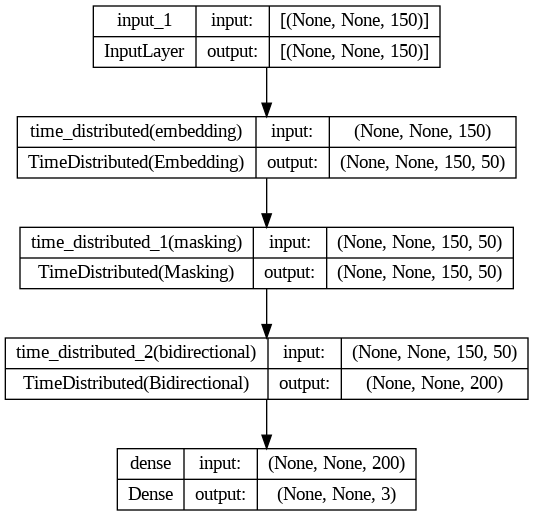

In [ ]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(model, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
history = model.fit(np.array(X_train), np.expand_dims(np.array(y_train), axis=-1),
                    batch_size=32,
                    epochs=3,  # You can change this
                    validation_split=0.2,
                    sample_weight=sample_weights)


Epoch 1/3


ValueError: ignored

In [ ]:
###  fitting for witout timedistributed modelo

# Assuming original X_train is a list of documents and each document is a list of sentences
X_train_flattened = [sentence for document in X_train for sentence in document]

# If y_train is also a list of documents (where each document has a label),
# you need to repeat each document label for each sentence in the document
y_train_flattened = [label for labels in y_train for label in labels]

In [ ]:
X_train_flattened = np.array(X_train_flattened)

In [ ]:
y_train_flattened = np.array(y_train_flattened)


In [ ]:
y_train_flattened.shape

(1924350,)

In [ ]:
X_train_flattened.shape

(1924350, 150)

In [ ]:
from keras import backend as K

# Clear the session before defining the model
K.clear_session()

In [ ]:
sample_weights_flattened = sample_weights.flatten()


In [ ]:
sample_weights_flattened.shape

(1924350,)

In [ ]:
history = model.fit(np.array(X_train_flattened), np.array(y_train_flattened),
                    batch_size=128,
                    epochs=3,  # You can change this
                    validation_split=0.2,
                    sample_weight=sample_weights_flattened)



Epoch 1/3
12028/12028 [==============================] - ETA: 0s - loss: 0.0065 - accuracy: 0.8054

12028/12028 [==============================] - 4052s 337ms/step - loss: 0.0065 - accuracy: 0.8054 - val_loss: 0.0162 - val_accuracy: 0.4472
Epoch 2/3
12028/12028 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.7110

12028/12028 [==============================] - 3971s 330ms/step - loss: 0.0050 - accuracy: 0.7110 - val_loss: 0.0175 - val_accuracy: 0.4125
Epoch 3/3
12028/12028 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 0.7245

12028/12028 [==============================] - 3985s 331ms/step - loss: 0.0041 - accuracy: 0.7245 - val_loss: 0.0194 - val_accuracy: 0.3974


In [ ]:
# Save the model
model_name = 'model_sent_06_1'
full_path = folder_path + model_name
model.save(full_path)

In [ ]:
X_test_flattened = np.array([word for sentence in X_test for word in sentence])
y_test_flattened = np.array([tag for sentence_tags in y_test for tag in sentence_tags])


In [ ]:
from sklearn.metrics import classification_report

# Assuming you have a test set (X_test_flattened, y_test_flattened)

# After training, get the predictions
y_pred = model.predict(X_test_flattened)

# As your model outputs probabilities, we need to convert them to class labels
y_pred = np.argmax(y_pred, axis=-1)

# No need to flatten as your arrays are already 1D
# y_pred = y_pred.flatten()
# y_test_labels = np.array(y_test_flattened).flatten()

# Exclude padding class (class 0) values for evaluation
idx = np.where(y_test_flattened!=0)  # Get the indices where label is not padding class
y_pred_no_pad = y_pred[idx]
y_test_labels_no_pad = y_test_flattened[idx]

print(classification_report(y_test_labels_no_pad, y_pred_no_pad, digits=4))


15038/15038 [==============================] - 458s 30ms/step
              precision    recall  f1-score   support

           1     0.9232    0.8193    0.8681     92385
           2     0.0853    0.1981    0.1192      7856

    accuracy                         0.7706    100241
   macro avg     0.5042    0.5087    0.4937    100241
weighted avg     0.8575    0.7706    0.8094    100241



In [ ]:
from sklearn.metrics import classification_report

# Assuming you have a test set (X_test, y_test)
# After training, get the predictions
y_pred = model.predict(X_test)

# As your model outputs probabilities, we need to convert them to class labels
y_pred = np.argmax(y_pred, axis=-1)

# Flatten both arrays because classification_report cannot deal with 3D arrays
y_pred = y_pred.flatten()
y_test_labels = np.array(y_test).flatten()

# Exclude padding class (class 0) values for evaluation
idx = np.where(y_test_labels!=0)  # Get the indices where label is not padding class
y_pred_no_pad = y_pred[idx]
y_test_labels_no_pad = y_test_labels[idx]

print(classification_report(y_test_labels_no_pad, y_pred_no_pad, digits=4))


101/101 [==============================] - 76s 744ms/step
              precision    recall  f1-score   support

           1     0.9222    0.4709    0.6235     92385
           2     0.0789    0.5326    0.1374      7856

    accuracy                         0.4758    100241
   macro avg     0.5005    0.5018    0.3804    100241
weighted avg     0.8561    0.4758    0.5854    100241



With Focal Loss

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def categorical_focal_loss(alpha, gamma=2.):
    """
    Softmax version of focal loss.
    """
    alpha = np.array(alpha, dtype=np.float32)

    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(K.sum(loss, axis=-1))

    return categorical_focal_loss_fixed


In [ ]:
alpha = [0, 0.1, 0.9]  # Set the alpha for padding class to 0
focal_loss = categorical_focal_loss(alpha, gamma=2.0)

In [ ]:

from tensorflow.keras.utils import to_categorical

num_classes = 3  # Since you have three classes: padding, normal text, and highlight.

y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

In [ ]:
model.compile(optimizer='adam', loss=focal_loss, metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, batch_size=32, epochs=3, sample_weight=sample_weights, validation_split=0.2, verbose=1)

Epoch 1/3
321/321 [==============================] - ETA: 0s - loss: 9.4454e-05 - accuracy: 0.7982

321/321 [==============================] - 897s 3s/step - loss: 9.4454e-05 - accuracy: 0.7982 - val_loss: 3.0809e-04 - val_accuracy: 0.5967
Epoch 2/3
321/321 [==============================] - ETA: 0s - loss: 7.6891e-05 - accuracy: 0.7982

321/321 [==============================] - 947s 3s/step - loss: 7.6891e-05 - accuracy: 0.7982 - val_loss: 2.8993e-04 - val_accuracy: 0.5967
Epoch 3/3
321/321 [==============================] - ETA: 0s - loss: 7.2504e-05 - accuracy: 0.7978

321/321 [==============================] - 879s 3s/step - loss: 7.2504e-05 - accuracy: 0.7978 - val_loss: 3.5791e-04 - val_accuracy: 0.5966


In [ ]:
# Save the model
model_name = 'model_sent_27_3_focal'
full_path = folder_path + model_name
model.save(full_path)

In [ ]:
print(y_pred.shape)
print(y_test_labels.shape)

(481200,)
(1443600,)


In [ ]:
y_pred = model.predict(X_test)
print(y_pred.shape)


101/101 [==============================] - 60s 585ms/step
(3208, 150, 3)


In [ ]:
y_test_labels = np.argmax(y_test, axis=-1)  # Get class labels
y_test_labels = y_test_labels.flatten()  # Flatten


In [ ]:
#y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)  # Get class labels
y_pred = y_pred.flatten()  # Flatten


In [ ]:
y_test_labels.shape

(481200,)

In [ ]:
y_pred.shape

(481200,)

In [ ]:
# Exclude padding class (class 0) values for evaluation
idx = np.where(y_test_labels!=0)  # Get the indices where label is not padding class
y_pred_no_pad = y_pred[idx]
y_test_labels_no_pad = y_test_labels[idx]

In [ ]:
y_test_labels_no_pad.shape

(315749,)

In [ ]:
y_pred_no_pad.shape

(315749,)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test_labels_no_pad, y_pred_no_pad, digits=4))

              precision    recall  f1-score   support

           1     0.9216    0.9998    0.9591     92385
           2     0.0588    0.0001    0.0003      7856

    accuracy                         0.9215    100241
   macro avg     0.4902    0.5000    0.4797    100241
weighted avg     0.8540    0.9215    0.8840    100241



### word level stuff


In [ ]:
### word level predictions ###


# Define the structure of the model
document_input = Input(shape=(None, longest_sentence), dtype='int32')  # change here
embedded_sequences = TimeDistributed(Embedding(input_dim= len_word_index +1, output_dim=50, input_length= longest_sentence))(document_input)  # change here
masked_sequences = TimeDistributed(Masking(mask_value=0))(embedded_sequences)  # change here
word_lstm = TimeDistributed(Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)))(masked_sequences)  # change here
word_attention = TimeDistributed(Dense(len_tag_index, activation='softmax'))(word_lstm)

# Create the model
model = Model(inputs=[document_input], outputs=[word_attention])  # change here

In [ ]:
### focal loss
alpha = [0, 0.25, 0.75]  # Set the alpha for padding class to 0
focal_loss = categorical_focal_loss(alpha, gamma=2.0)

In [ ]:
# # Compile the model
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.compile(optimizer='adam', loss=focal_loss, metrics=['accuracy'])



In [ ]:
print(X_train.shape)

(12829, 150, 150)


In [ ]:
y_train.shape

(12829, 150, 150)

In [ ]:
from tensorflow.keras.utils import to_categorical

num_classes = 3  # Since you have three classes: padding, normal text, and highlight.

y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)


In [ ]:
y_train.shape

(12829, 150, 150, 3)

In [ ]:
# # Train the model with focal loss & sample weights
model.fit(X_train, y_train, batch_size=8, epochs=3, sample_weight=sample_weights, validation_split=0.2, verbose=1)

In [ ]:
# # Train the model with focal loss only
model.fit(X_train, y_train, batch_size=8, epochs=3, validation_split=0.2, verbose=1)

Epoch 1/3
1283/1283 [==============================] - 1578s 1s/step - loss: 0.0105 - accuracy: 0.6455 - val_loss: 0.0099 - val_accuracy: 0.6409
Epoch 2/3
1283/1283 [==============================] - 1484s 1s/step - loss: 0.0094 - accuracy: 0.6457 - val_loss: 0.0090 - val_accuracy: 0.6408
Epoch 3/3
1283/1283 [==============================] - 1431s 1s/step - loss: 0.0089 - accuracy: 0.6457 - val_loss: 0.0089 - val_accuracy: 0.6406


In [ ]:
# Save the model to a HDF5 file
model.save('lstm_sent_150_19_model1.h5')

# Download the file
#from google.colab import files
#files.download('lstm_sent_150_18_model1.h5')


In [ ]:
# Predicting
y_pred = model.predict(X_test)

# Convert probabilities into class labels
y_pred = np.argmax(y_pred, axis=-1)

# Reshaping predictions to original shape
y_pred = y_pred.reshape((-1, 150, 150))

# For true labels, assuming y_test has the original 3D shape (num_samples, num_sentences_per_document, num_tokens_per_sentence)
y_test_labels = np.array(y_test)

# Remove padding tokens for evaluation
y_pred_no_pad = []
y_test_labels_no_pad = []
for doc_pred, doc_true in zip(y_pred, y_test_labels):
    for sent_pred, sent_true in zip(doc_pred, doc_true):
        # Get indices where true label is not padding class
        idx = np.where(sent_true != 0)
        y_pred_no_pad.extend(sent_pred[idx])
        y_test_labels_no_pad.extend(sent_true[idx])

print(classification_report(y_test_labels_no_pad, y_pred_no_pad, digits=4))


101/101 [==============================] - 11s 111ms/step


IndexError: ignored

In [ ]:
# Exclude padding class (class 0) values for evaluation
y_pred_no_pad = []
y_test_labels_no_pad = []
for doc_pred, doc_true in zip(y_pred, y_test_labels):
    for label_pred, label_true in zip(doc_pred, doc_true):
        # if label_true contains any non-zero elements (i.e., not padding)
        if np.any(label_true != 0):
            y_pred_no_pad.extend(label_pred)
            y_test_labels_no_pad.extend(label_true)

# Make the lists into numpy arrays
y_pred_no_pad = np.array(y_pred_no_pad)
y_test_labels_no_pad = np.array(y_test_labels_no_pad)

# Get the indices where label is not padding class
idx = np.where(y_test_labels_no_pad != 0)
y_pred_no_pad = y_pred_no_pad[idx]
y_test_labels_no_pad = y_test_labels_no_pad[idx]

print(classification_report(y_test_labels_no_pad, y_pred_no_pad, digits=4))



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

def categorical_focal_loss(gamma=2.):
    alpha = np.array([0, 0.25, 0.75], dtype=np.float32)  # Set the alpha for padding class to 0
    """
    Softmax version of focal loss.
    """
    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(K.sum(loss, axis=-1))

    return categorical_focal_loss_fixed

focal_loss = categorical_focal_loss(gamma=2.0)

# Load the model from a HDF5 file
model = load_model('lstm_sent_150_18_model1.h5', custom_objects={'categorical_focal_loss_fixed': focal_loss})


In [ ]:
from sklearn.metrics import classification_report

# Assuming you have a test set (X_test, y_test)
# After training, get the predictions
y_pred = model.predict(X_test)

# As your model outputs probabilities, we need to convert them to class labels
y_pred = np.argmax(y_pred, axis=-1)

# Flatten both arrays because classification_report cannot deal with 3D arrays
y_pred = y_pred.flatten()
y_test_labels = np.array(y_test).flatten()

# Exclude padding class (class 0) values for evaluation
idx = np.where(y_test_labels!=0)  # Get the indices where label is not padding class
y_pred_no_pad = y_pred[idx]
y_test_labels_no_pad = y_test_labels[idx]

print(classification_report(y_test_labels_no_pad, y_pred_no_pad, digits=4))


101/101 [==============================] - 12s 109ms/step


IndexError: ignored

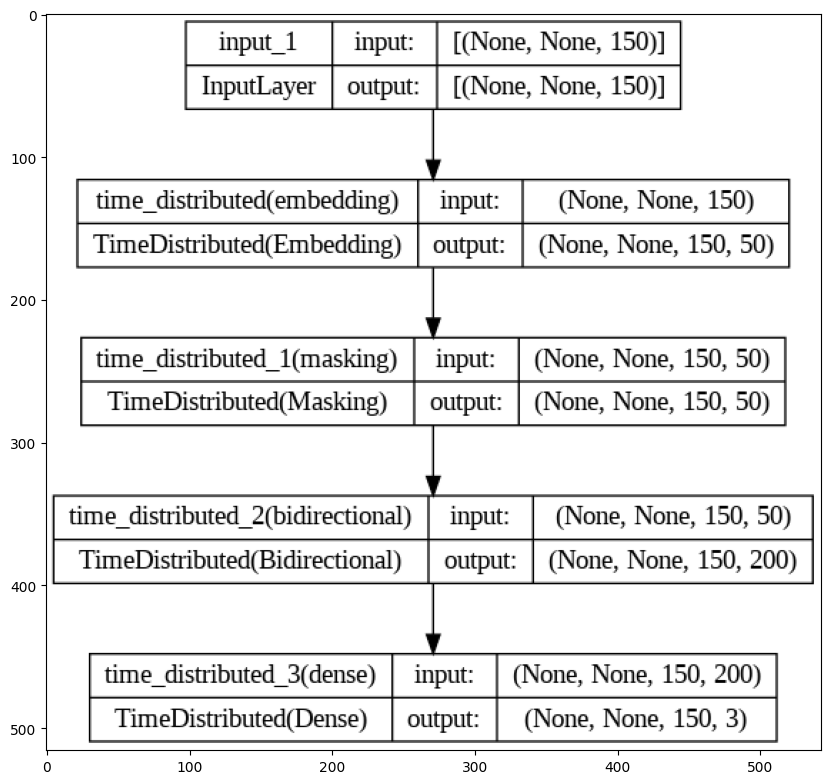

In [ ]:
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# First, save the plot as a PNG file
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Then, load the image and display it
img = mpimg.imread('model_plot.png')
plt.figure(figsize=(10, 15))  # Optional: adjust this to change image size
imgplot = plt.imshow(img)
plt.show()


Old Code


In [ ]:
# Open the file 'dataX.h5' in read mode ('r')
with h5py.File('/content/drive/MyDrive/thesis_files/dataX_s.h5', 'r') as hf:
    X = hf['X'][:]
with h5py.File('/content/drive/MyDrive/thesis_files/datay_s.h5', 'r') as hf:
    y = hf['y'][:]

In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [ ]:
# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Define the model
model = Sequential()
model.add(Embedding(input_dim=444983, output_dim=50, input_length=X.shape[1]))
model.add(Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)))
model.add(TimeDistributed(Dense(2, activation='softmax')))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, np.array(y_train), batch_size= 32, epochs=3, validation_split=0.2, verbose=1)

Epoch 1/3


ResourceExhaustedError: ignored